# AlexNet architecture on Pytorch from scratch
This is just a showcase of my machine learning studies. This model is unlikely to perform well on more complex dataset. This project is done by following this tutorial on youtube: https://www.youtube.com/watch?v=tHL5STNJKag&t=1587s and I made modification to use custom machine learning model instead of pretrained models.

I am using Fasion-MNIST dataset from kaggle since it is a very popular dataset for machine learning.

### Create dataset class

The FashionDataset class simplifies image loading for deep learning models. It uses ImageFolder to automatically assign labels based on folder names and supports transformations for preprocessing.

In [242]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [243]:
class FashionDataset(Dataset):
    def __init__(self, data_directory, transform = None):
        self.data = ImageFolder(data_directory, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
    
    @property
    def classes(self):
        return self.data.classes

### Testing out dataset class by calling their functions

In [244]:
dataset = FashionDataset(data_directory="./data/train")

In [245]:
image, label = dataset[6500]
print(label)
image

1


In [ ]:
transform = transforms.Compose([
    #Can add transforms.Grayscale() here since Fashion-MNIST is a dataset with grayscale images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = FashionDataset(data_directory="./data/train", transform=transform)

### Test out the data loader class


In [331]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Building a Scaled-Down AlexNet-Based Model for Fashion MNIST Using PyTorch 
The original AlexNet was built for high-resolution, RGB images, but here, it is optimized for a smaller data with images having 28x28 resolution.

Some modification include:
- Fewer convolutional layers (3 instead of 5) to suit the Fashion MNIST dataset.

- Smaller kernel sizes and stride adjustments to align with the lower resolution.

- Fully connected layers tailored for feature extraction while maintaining depth.

In [377]:
import torch.nn.functional as F
class FashionClassifier(nn.Module):
    def __init__(self, num_classes = 10):
        super(FashionClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.ReLU(),
            
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
model = FashionClassifier()
print(model)

FashionClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Write a simple training loop
This script implements a training loop for a deep learning model using PyTorch. It optimizes a FashionClassifier model for image classification while tracking training and validation accuracy. A progress bar (tqdm) provides real-time updates, making it easy to monitor the training process.

Key Features

- Automatic Device Selection: Runs on GPU (cuda) if available, otherwise defaults to CPU
- Model Training & Optimization: Uses CrossEntropyLoss and Adam optimizer to update weights.
- Batch-wise Progress Tracking: Displays loss and accuracy updates for each epoch using tqdm
- Validation Accuracy Computation: Evaluates model on the test set after every epoch and stores results for future analysis.

In [376]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [379]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to (-1, 1) range
])

train_folder_dir = "./data/train"
test_folder_dir = "./data/test"

train_dataset = FashionDataset(train_folder_dir, transform=transform)
test_dataset = FashionDataset(test_folder_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [380]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break  # Print just one batch

print(len(train_dataset))  # Check total samples
image, label = train_dataset[0]
print(type(image), image.size, label)  # Verify data
print(dataset.classes) 

torch.Size([128, 3, 28, 28]) torch.Size([128])
60000
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x0000028C0FCB8AF0> 0
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [381]:
from tqdm import tqdm

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = FashionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accuracies, val_accuracies = [], []
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)  # Move data to device
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print epoch results
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    print("Training complete!")

    # Test loop
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy  = 100 * correct / total
    val_accuracies.append(val_accuracy )

    print(f"Test Accuracy: {val_accuracy :.2f}%")

Using device: cuda


Epoch 1/10: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s]


Epoch [1/10], Loss: 0.5010, Accuracy: 81.29%
Training complete!
Test Accuracy: 88.26%


Epoch 2/10: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


Epoch [2/10], Loss: 0.2836, Accuracy: 89.63%
Training complete!
Test Accuracy: 89.99%


Epoch 3/10: 100%|██████████| 469/469 [00:46<00:00, 10.03it/s]


Epoch [3/10], Loss: 0.2306, Accuracy: 91.57%
Training complete!
Test Accuracy: 91.06%


Epoch 4/10: 100%|██████████| 469/469 [00:44<00:00, 10.66it/s]


Epoch [4/10], Loss: 0.1988, Accuracy: 92.61%
Training complete!
Test Accuracy: 91.44%


Epoch 5/10: 100%|██████████| 469/469 [00:45<00:00, 10.35it/s]


Epoch [5/10], Loss: 0.1708, Accuracy: 93.71%
Training complete!
Test Accuracy: 90.85%


Epoch 6/10: 100%|██████████| 469/469 [00:45<00:00, 10.33it/s]


Epoch [6/10], Loss: 0.1478, Accuracy: 94.53%
Training complete!
Test Accuracy: 91.83%


Epoch 7/10: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


Epoch [7/10], Loss: 0.1281, Accuracy: 95.23%
Training complete!
Test Accuracy: 91.44%


Epoch 8/10: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]


Epoch [8/10], Loss: 0.1092, Accuracy: 95.88%
Training complete!
Test Accuracy: 91.90%


Epoch 9/10: 100%|██████████| 469/469 [00:47<00:00,  9.94it/s]


Epoch [9/10], Loss: 0.0955, Accuracy: 96.45%
Training complete!
Test Accuracy: 91.65%


Epoch 10/10: 100%|██████████| 469/469 [00:45<00:00, 10.20it/s]


Epoch [10/10], Loss: 0.0804, Accuracy: 96.99%
Training complete!
Test Accuracy: 91.87%


### Show the training and validation data on a plot for easy visualization

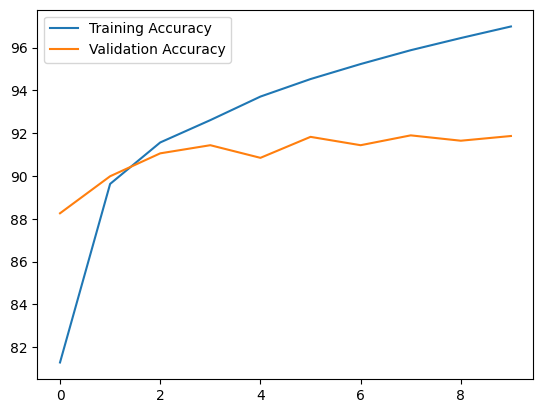

In [ ]:
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()